          vm_pu  va_degree      p_mw   q_mvar
name                                         
Barra 1  1.0000     0.0000 -226.8220 276.4582
Barra 2  1.3549   -11.8953    0.0000   0.0000
Barra 1A 1.3452   -12.7028   30.0000  20.0000
Barra 1B 1.3477   -12.7549   15.0000  10.0000
Barra 2A 1.3345   -13.5762   52.5000  35.0000
Barra 2B 1.3272   -14.0118   90.0000  60.0000
Barra 3A 1.3293   -14.1437   22.5000  15.0000
        p_from_mw  q_from_mvar   p_to_mw  q_to_mvar  pl_mw   ql_mvar  \
name                                                                   
L2-1A    123.1022    -207.0415 -119.7247   149.2779 3.3775  -57.7635   
L2-1B    100.3196    -222.8618  -96.8855   165.0003 3.4342  -57.8615   
L1A-2A    89.7247    -169.2779  -87.0957    83.6299 2.6291  -85.6480   
L2A-3A    34.5957    -118.6299  -33.8491     5.4364 0.7465 -113.1934   
L1B-2B    81.8855    -175.0003  -78.7193     4.0541 3.1662 -170.9462   
L2B-3A   -11.2807     -64.0541   11.3491   -20.4364 0.0684  -84.4905   

        i

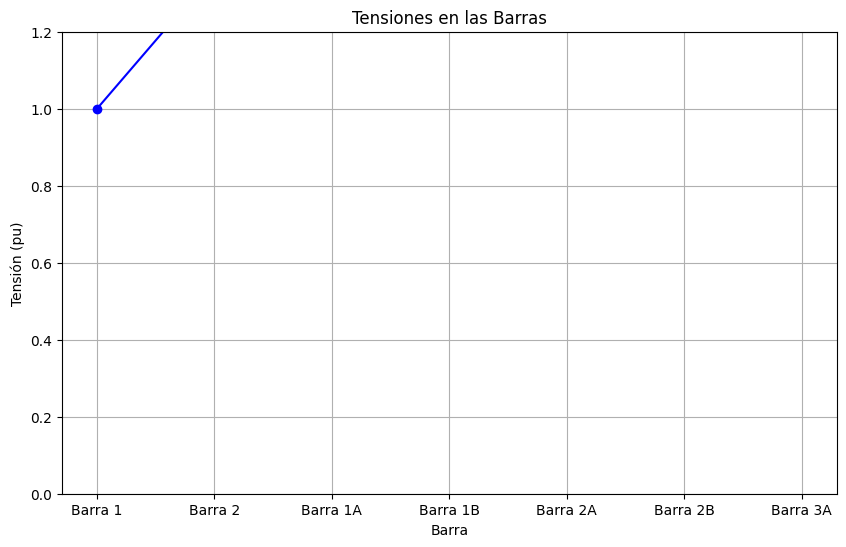

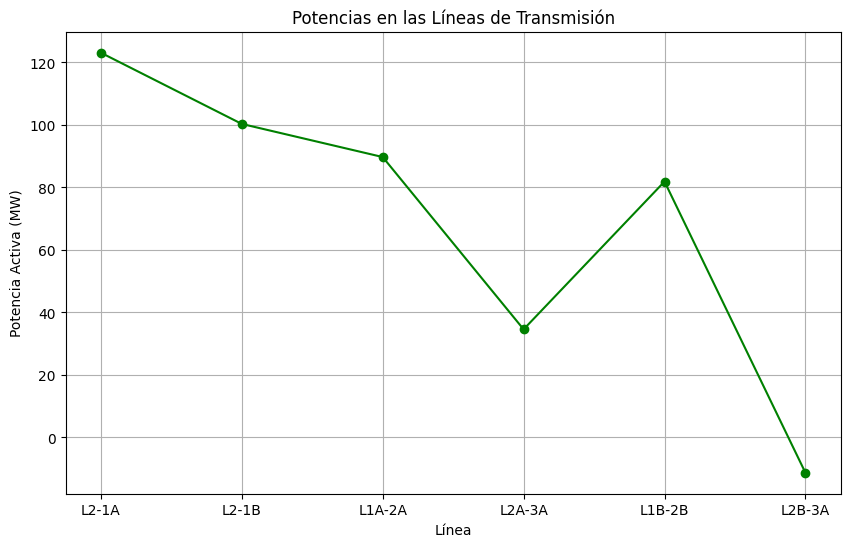

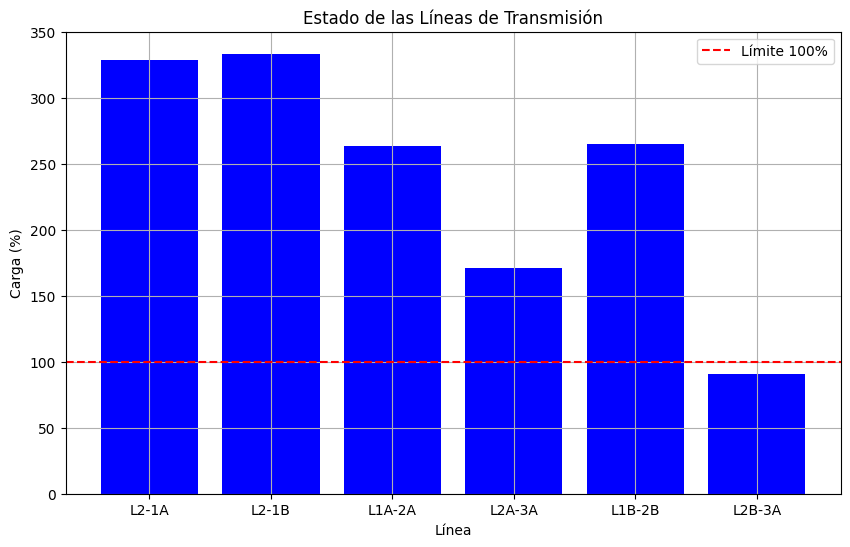

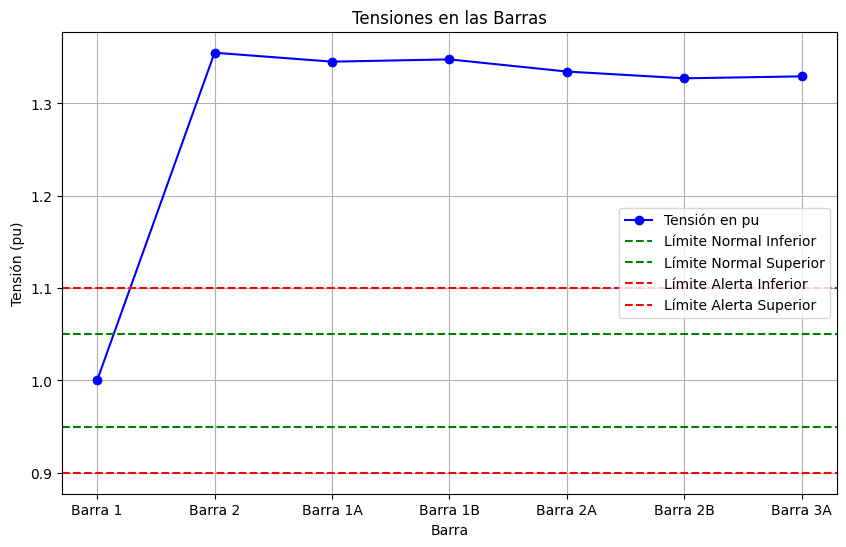

In [185]:
import numpy as np
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))

# Crear la red a analizar
red2 = pp.create_empty_network()

# Creación de las barras del sistema
barra_1 = pp.create_bus(red2, vn_kv=110, name="Barra 1")
barra_2 = pp.create_bus(red2, vn_kv=220, name="Barra 2")
barra_1A = pp.create_bus(red2, vn_kv=220, name="Barra 1A")
barra_1B = pp.create_bus(red2, vn_kv=220, name="Barra 1B")
barra_2A = pp.create_bus(red2, vn_kv=220, name="Barra 2A")
barra_2B = pp.create_bus(red2, vn_kv=220, name="Barra 2B")
barra_3A = pp.create_bus(red2, vn_kv=220, name="Barra 3A")

# Añadir transformador entre barra 1 y 2
pp.create_transformer(red2, barra_2, barra_1, std_type="100 MVA 220/110 kV")

# Añadir el generador en la barra 1 y que dicha barra sea la referencia
pp.create_ext_grid(red2, barra_1, va_pu=1.0, name="Slack")

# Crear las líneas
pp.create_line(red2, barra_2, barra_1A, length_km=10.0, std_type="NAYY 4x50 SE", name="L2-1A")
pp.create_line(red2, barra_2, barra_1B, length_km=10.0, std_type="NAYY 4x50 SE", name="L2-1B")
pp.create_line(red2, barra_1A, barra_2A, length_km=15.0, std_type="NAYY 4x50 SE", name="L1A-2A")
pp.create_line(red2, barra_2A, barra_3A, length_km=20.0, std_type="NAYY 4x50 SE", name="L2A-3A")
pp.create_line(red2, barra_1B, barra_2B, length_km=30.0, std_type="NAYY 4x50 SE", name="L1B-2B")
pp.create_line(red2, barra_2B, barra_3A, length_km=15.0, std_type="NAYY 4x50 SE", name="L2B-3A")

# Crear las cargas
pp.create_load(red2, barra_1A, p_mw=30.0, q_mvar=20.0, name="Carga Barra 1A")
pp.create_load(red2, barra_2A, p_mw=52.5, q_mvar=35.0, name="Carga Barra 2A")
pp.create_load(red2, barra_3A, p_mw=22.5, q_mvar=15.0, name="Carga Barra 3A")
pp.create_load(red2, barra_1B, p_mw=15.0, q_mvar=10.0, name="Carga Barra 1B")
pp.create_load(red2, barra_2B, p_mw=90.0, q_mvar=60.0, name="Carga Barra 2B")

# Ejecutar el flujo de carga
pp.runpp(red2, algorithm='nr', numba=False, max_iteration=1000)

# Imprimir los resultados
red2.res_line.index = red2.line.name
red2.res_bus.index = red2.bus.name

print(red2.res_bus)
print(red2.res_line)

# Graficar las tensiones en las barras
voltages = red2.res_bus.vm_pu
bars = red2.bus.name

plt.figure(figsize=(10, 6))
plt.plot(bars, voltages, marker='o', linestyle='-', color='blue')
plt.xlabel('Barra')
plt.ylabel('Tensión (pu)')
plt.title('Tensiones en las Barras')
plt.ylim([0, 1.2])
plt.grid(True)
plt.show()

# Graficar las potencias en las líneas de transmisión
powers = red2.res_line.p_from_mw
lines = red2.line.name

plt.figure(figsize=(10, 6))
plt.plot(lines, powers, marker='o', linestyle='-', color='green')
plt.xlabel('Línea')
plt.ylabel('Potencia Activa (MW)')
plt.title('Potencias en las Líneas de Transmisión')
plt.grid(True)
plt.show()

# Identificar líneas saturadas
saturated_lines = red2.res_line[red2.res_line.loading_percent > 100]

# Graficar el estado de cada línea
plt.figure(figsize=(10, 6))
plt.bar(red2.res_line.index, red2.res_line.loading_percent, color='blue')
plt.axhline(y=100, color='r', linestyle='--', label='Límite 100%')
plt.xlabel('Línea')
plt.ylabel('Carga (%)')
plt.title('Estado de las Líneas de Transmisión')
plt.legend()
plt.grid(True)
plt.show()

# Definir los límites de tensión
limite_inferior_normal = 0.95
limite_superior_normal = 1.05
limite_inferior_alerta = 0.90
limite_superior_alerta = 1.10

# Verificar tensiones en estado normal
fuera_de_norma_normal = red2.res_bus[(red2.res_bus.vm_pu < limite_inferior_normal) | (red2.res_bus.vm_pu > limite_superior_normal)]

# Verificar tensiones en estado de alerta
fuera_de_norma_alerta = red2.res_bus[(red2.res_bus.vm_pu < limite_inferior_alerta) | (red2.res_bus.vm_pu > limite_superior_alerta)]

# Graficar las tensiones
plt.figure(figsize=(10, 6))
plt.plot(red2.res_bus.index, red2.res_bus.vm_pu, marker='o', linestyle='-', color='blue', label='Tensión en pu')
plt.axhline(y=limite_inferior_normal, color='g', linestyle='--', label='Límite Normal Inferior')
plt.axhline(y=limite_superior_normal, color='g', linestyle='--', label='Límite Normal Superior')
plt.axhline(y=limite_inferior_alerta, color='r', linestyle='--', label='Límite Alerta Inferior')
plt.axhline(y=limite_superior_alerta, color='r', linestyle='--', label='Límite Alerta Superior')
plt.xlabel('Barra')
plt.ylabel('Tensión (pu)')
plt.title('Tensiones en las Barras')
plt.legend()
plt.grid(True)
plt.show()


Resultados antes de desconectar la línea 3A-2B:
   vm_pu  va_degree      p_mw    q_mvar
0 1.0000     0.0000 -217.1897 -355.2113
1 0.6213   -23.8586    0.0000    0.0000
2 0.6113   -24.7533   30.0000   20.0000
3 0.6132   -24.5787   15.0000   10.0000
4 0.6003   -25.7838   52.5000   35.0000
5 0.5929   -26.4762   90.0000   60.0000
6 0.5945   -26.3373   22.5000   15.0000
   p_from_mw  q_from_mvar   p_to_mw  q_to_mvar  i_from_ka  i_to_ka  \
0   117.6477      81.4509 -116.9996   -78.8979     0.6044   0.6058   
1    95.0008      65.7998  -94.5778   -64.3361     0.4881   0.4895   
2    86.9996      58.8979  -86.4570   -57.1143     0.4510   0.4530   
3    33.9570      22.1143  -33.8443   -22.6547     0.1772   0.1798   
4    79.5778      54.3361  -78.6657   -51.5898     0.4124   0.4164   
5   -11.3343      -8.4102   11.3443     7.6547     0.0625   0.0604   

   loading_percent  
0          63.1028  
1          50.9912  
2          47.1902  
3          18.7287  
4          43.3735  
5           6.5

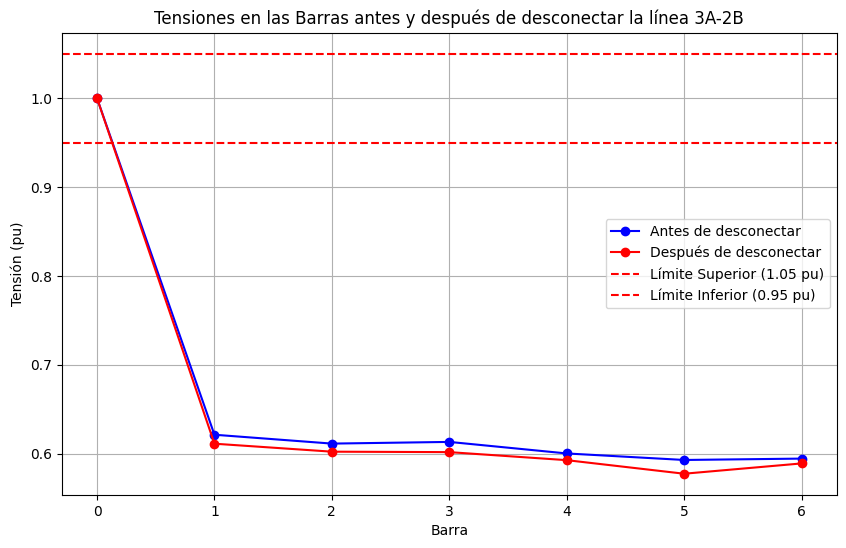

In [186]:
import numpy as np
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))

# Crear la red a analizar
red2 = pp.create_empty_network()

# Creación de las barras del sistema
barra_1 = pp.create_bus(red2, vn_kv=110, name="Barra 1")
barra_2 = pp.create_bus(red2, vn_kv=220, name="Barra 2")
barra_1A = pp.create_bus(red2, vn_kv=220, name="Barra 1A")
barra_1B = pp.create_bus(red2, vn_kv=220, name="Barra 1B")
barra_2A = pp.create_bus(red2, vn_kv=220, name="Barra 2A")
barra_2B = pp.create_bus(red2, vn_kv=220, name="Barra 2B")
barra_3A = pp.create_bus(red2, vn_kv=220, name="Barra 3A")

# Añadir transformador entre barra 1 y 2
pp.create_transformer(red2, barra_2, barra_1, std_type="100 MVA 220/110 kV")

# Añadir el generador en la barra 1 y que dicha barra sea la referencia
pp.create_ext_grid(red2, barra_1, va_pu=1.0, name="Slack")

# Crear las líneas utilizando el tipo de línea con menor capacidad de transferencia
linea_min_capacidad = "490-AL1/64-ST1A 220.0"  # Línea con menor capacidad de transferencia

# Crear las líneas
pp.create_line(red2, barra_2, barra_1A, length_km=10.0, std_type=linea_min_capacidad, name="L2-1A")
pp.create_line(red2, barra_2, barra_1B, length_km=10.0, std_type=linea_min_capacidad, name="L2-1B")
pp.create_line(red2, barra_1A, barra_2A, length_km=15.0, std_type=linea_min_capacidad, name="L1A-2A")
pp.create_line(red2, barra_2A, barra_3A, length_km=20.0, std_type=linea_min_capacidad, name="L2A-3A")
pp.create_line(red2, barra_1B, barra_2B, length_km=30.0, std_type=linea_min_capacidad, name="L1B-2B")
line6 = pp.create_line(red2, barra_2B, barra_3A, length_km=15.0, std_type=linea_min_capacidad, name="L2B-3A")

# Crear las cargas
pp.create_load(red2, barra_1A, p_mw=30.0, q_mvar=20.0, name="Carga Barra 1A")
pp.create_load(red2, barra_2A, p_mw=52.5, q_mvar=35.0, name="Carga Barra 2A")
pp.create_load(red2, barra_3A, p_mw=22.5, q_mvar=15.0, name="Carga Barra 3A")
pp.create_load(red2, barra_1B, p_mw=15.0, q_mvar=10.0, name="Carga Barra 1B")
pp.create_load(red2, barra_2B, p_mw=90.0, q_mvar=60.0, name="Carga Barra 2B")

# Ejecutar el flujo de carga
pp.runpp(red2, algorithm='nr', numba=False, max_iteration=1000)

# Imprimir los resultados antes de desconectar la línea
print("Resultados antes de desconectar la línea 3A-2B:")
print(red2.res_bus)
print(red2.res_line[['p_from_mw', 'q_from_mvar', 'p_to_mw', 'q_to_mvar', 'i_from_ka', 'i_to_ka', 'loading_percent']])

# Graficar las tensiones en las barras antes y después de desconectar la línea
voltages_before = red2.res_bus.vm_pu

# Desconectar la línea 3A-2B utilizando switches
switch_1 = pp.create_switch(red2, bus=barra_2B, element=line6, et='l', closed=False, name="Switch 3A-2B")

pp.runpp(red2, algorithm='nr', numba=False, max_iteration=1000)
voltages_after = red2.res_bus.vm_pu

# Imprimir los resultados después de desconectar la línea
print("Resultados después de desconectar la línea 3A-2B:")
print(red2.res_bus)
print(red2.res_line[['p_from_mw', 'q_from_mvar', 'p_to_mw', 'q_to_mvar', 'i_from_ka', 'i_to_ka', 'loading_percent']])

plt.figure(figsize=(10, 6))
plt.plot(red2.res_bus.index, voltages_before, marker='o', linestyle='-', color='blue', label='Antes de desconectar')
plt.plot(red2.res_bus.index, voltages_after, marker='o', linestyle='-', color='red', label='Después de desconectar')
plt.axhline(y=1.05, color='r', linestyle='--', label='Límite Superior (1.05 pu)')
plt.axhline(y=0.95, color='r', linestyle='--', label='Límite Inferior (0.95 pu)')
plt.xlabel('Barra')
plt.ylabel('Tensión (pu)')
plt.title('Tensiones en las Barras antes y después de desconectar la línea 3A-2B')
plt.legend()
plt.grid(True)
plt.show()


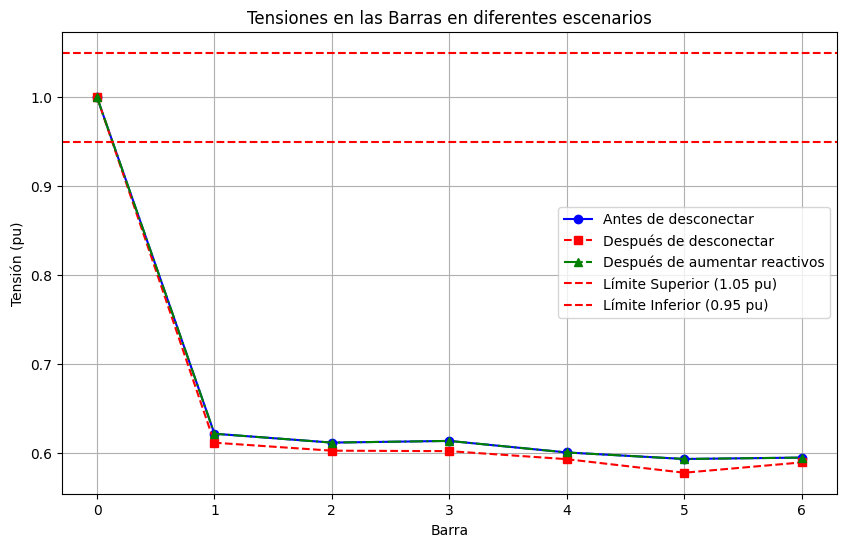

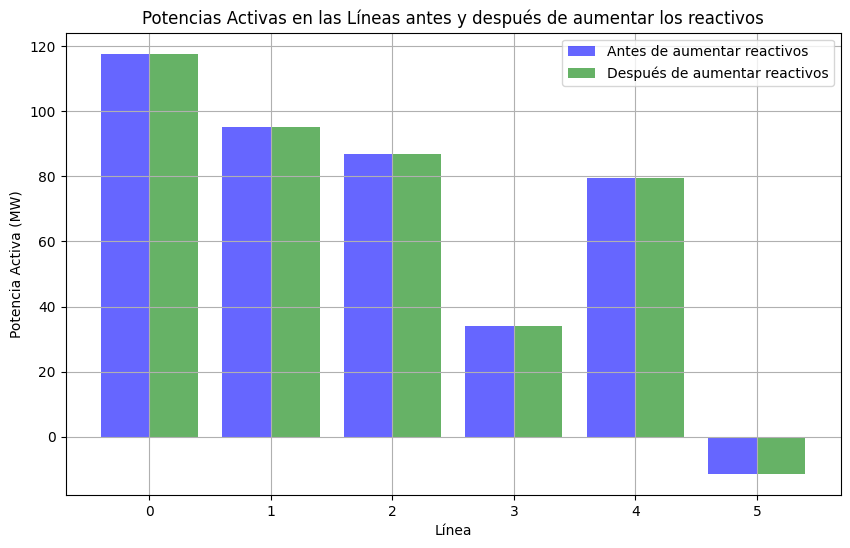

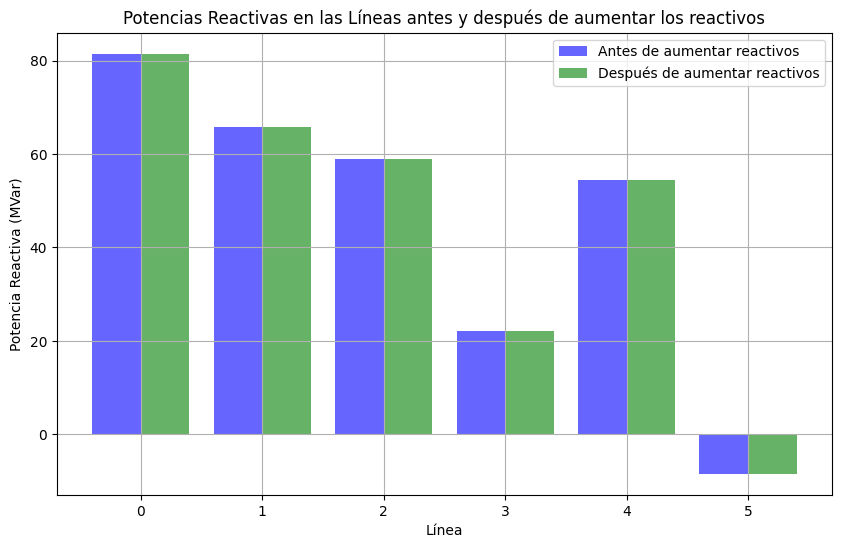

In [187]:
import numpy as np
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))

# Crear la red a analizar
red2 = pp.create_empty_network()

# Creación de las barras del sistema
barra_1 = pp.create_bus(red2, vn_kv=110, name="Barra 1")
barra_2 = pp.create_bus(red2, vn_kv=220, name="Barra 2")
barra_1A = pp.create_bus(red2, vn_kv=220, name="Barra 1A")
barra_1B = pp.create_bus(red2, vn_kv=220, name="Barra 1B")
barra_2A = pp.create_bus(red2, vn_kv=220, name="Barra 2A")
barra_2B = pp.create_bus(red2, vn_kv=220, name="Barra 2B")
barra_3A = pp.create_bus(red2, vn_kv=220, name="Barra 3A")

# Añadir transformador entre barra 1 y 2
pp.create_transformer(red2, barra_2, barra_1, std_type="100 MVA 220/110 kV")

# Añadir el generador en la barra 1 y que dicha barra sea la referencia
ext_grid_index = pp.create_ext_grid(red2, barra_1, va_pu=1.0, name="Slack")

# Crear las líneas utilizando el tipo de línea con menor capacidad de transferencia
linea_min_capacidad = "490-AL1/64-ST1A 220.0"  # Línea con menor capacidad de transferencia

# Crear las líneas
pp.create_line(red2, barra_2, barra_1A, length_km=10.0, std_type=linea_min_capacidad, name="L2-1A")
pp.create_line(red2, barra_2, barra_1B, length_km=10.0, std_type=linea_min_capacidad, name="L2-1B")
pp.create_line(red2, barra_1A, barra_2A, length_km=15.0, std_type=linea_min_capacidad, name="L1A-2A")
pp.create_line(red2, barra_2A, barra_3A, length_km=20.0, std_type=linea_min_capacidad, name="L2A-3A")
pp.create_line(red2, barra_1B, barra_2B, length_km=30.0, std_type=linea_min_capacidad, name="L1B-2B")
line6 = pp.create_line(red2, barra_2B, barra_3A, length_km=15.0, std_type=linea_min_capacidad, name="L2B-3A")

# Crear las cargas
pp.create_load(red2, barra_1A, p_mw=30.0, q_mvar=20.0, name="Carga Barra 1A")
pp.create_load(red2, barra_2A, p_mw=52.5, q_mvar=35.0, name="Carga Barra 2A")
pp.create_load(red2, barra_3A, p_mw=22.5, q_mvar=15.0, name="Carga Barra 3A")
pp.create_load(red2, barra_1B, p_mw=15.0, q_mvar=10.0, name="Carga Barra 1B")
pp.create_load(red2, barra_2B, p_mw=90.0, q_mvar=60.0, name="Carga Barra 2B")

# Ejecutar el flujo de carga
pp.runpp(red2, algorithm='nr', numba=False, max_iteration=1000)

# Guardar resultados antes de aumentar los reactivos
p_from_mw_before = red2.res_line.p_from_mw.copy()
q_from_mvar_before = red2.res_line.q_from_mvar.copy()

# Aumentar la inyección de reactivos en un 20%
original_q_mvar = red2.res_ext_grid['q_mvar'].iloc[0] if 'q_mvar' in red2.res_ext_grid else 0
new_q_mvar = original_q_mvar * 1.20 if original_q_mvar != 0 else 0.20  # Aumenta un 20%

# Actualizar la inyección de reactivos en el generador slack usando el índice correcto
red2.ext_grid.at[ext_grid_index, 'max_q_mvar'] = new_q_mvar
red2.ext_grid.at[ext_grid_index, 'min_q_mvar'] = -new_q_mvar  # También actualizamos el mínimo para ser coherentes

# Ejecutar el flujo de carga después de la reconexión y aumento de reactivos
pp.runpp(red2, algorithm='nr', numba=False, max_iteration=1000)

# Guardar resultados después de aumentar los reactivos
p_from_mw_after = red2.res_line.p_from_mw.copy()
q_from_mvar_after = red2.res_line.q_from_mvar.copy()

# Graficar las tensiones en las barras antes y después de aumentar los reactivos
voltages_final = red2.res_bus.vm_pu.copy()

plt.figure(figsize=(10, 6))
plt.plot(red2.res_bus.index, voltages_before, marker='o', linestyle='-', color='blue', label='Antes de desconectar')
plt.plot(red2.res_bus.index, voltages_after, marker='s', linestyle='--', color='red', label='Después de desconectar')
plt.plot(red2.res_bus.index, voltages_final, marker='^', linestyle='-.', color='green', label='Después de aumentar reactivos')
plt.axhline(y=1.05, color='r', linestyle='--', label='Límite Superior (1.05 pu)')
plt.axhline(y=0.95, color='r', linestyle='--', label='Límite Inferior (0.95 pu)')
plt.xlabel('Barra')
plt.ylabel('Tensión (pu)')
plt.title('Tensiones en las Barras en diferentes escenarios')
plt.legend()
plt.grid(True)
plt.show()

# Graficar las potencias activas en las líneas antes y después de aumentar los reactivos
plt.figure(figsize=(10, 6))
plt.bar(red2.res_line.index - 0.2, p_from_mw_before, width=0.4, color='blue', alpha=0.6, label='Antes de aumentar reactivos')
plt.bar(red2.res_line.index + 0.2, p_from_mw_after, width=0.4, color='green', alpha=0.6, label='Después de aumentar reactivos')
plt.xlabel('Línea')
plt.ylabel('Potencia Activa (MW)')
plt.title('Potencias Activas en las Líneas antes y después de aumentar los reactivos')
plt.legend()
plt.grid(True)
plt.show()

# Graficar las potencias reactivas en las líneas antes y después de aumentar los reactivos
plt.figure(figsize=(10, 6))
plt.bar(red2.res_line.index - 0.2, q_from_mvar_before, width=0.4, color='blue', alpha=0.6, label='Antes de aumentar reactivos')
plt.bar(red2.res_line.index + 0.2, q_from_mvar_after, width=0.4, color='green', alpha=0.6, label='Después de aumentar reactivos')
plt.xlabel('Línea')
plt.ylabel('Potencia Reactiva (MVar)')
plt.title('Potencias Reactivas en las Líneas antes y después de aumentar los reactivos')
plt.legend()
plt.grid(True)
plt.show()


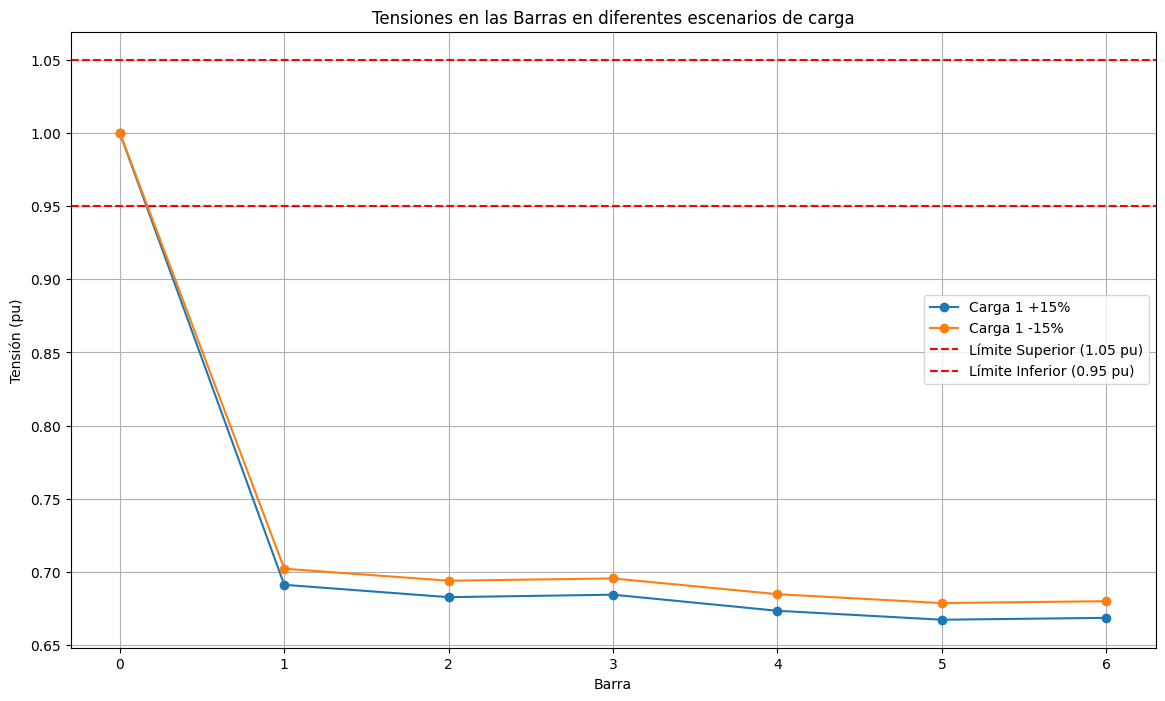

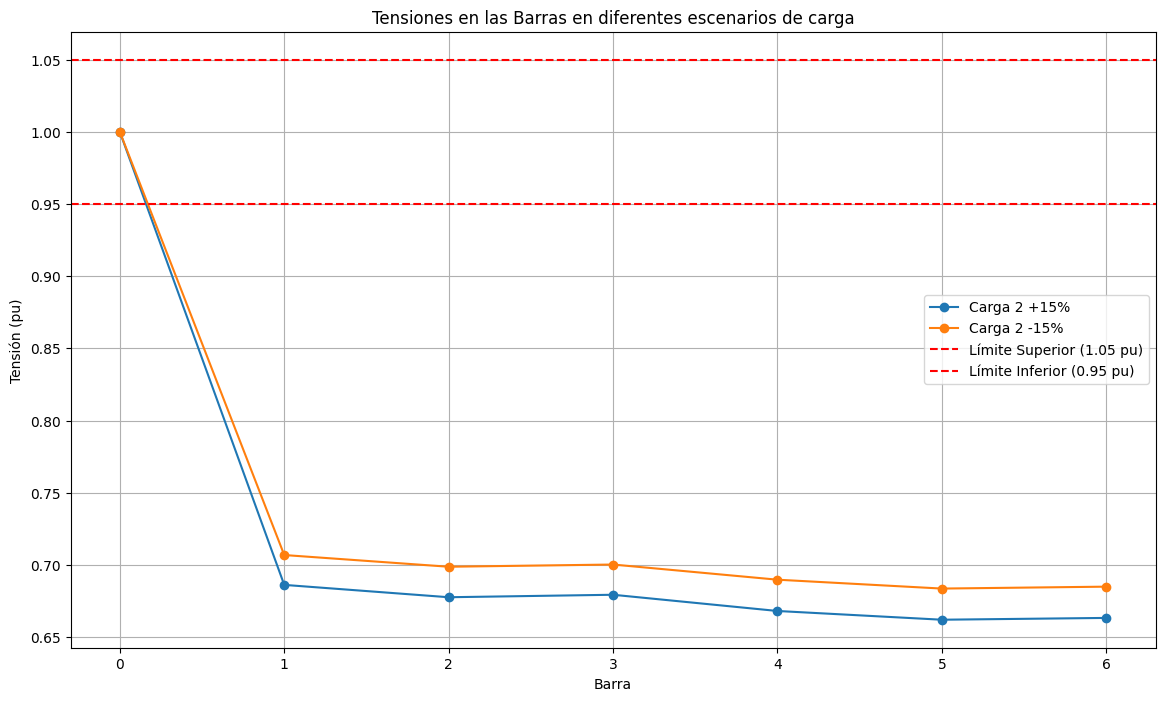

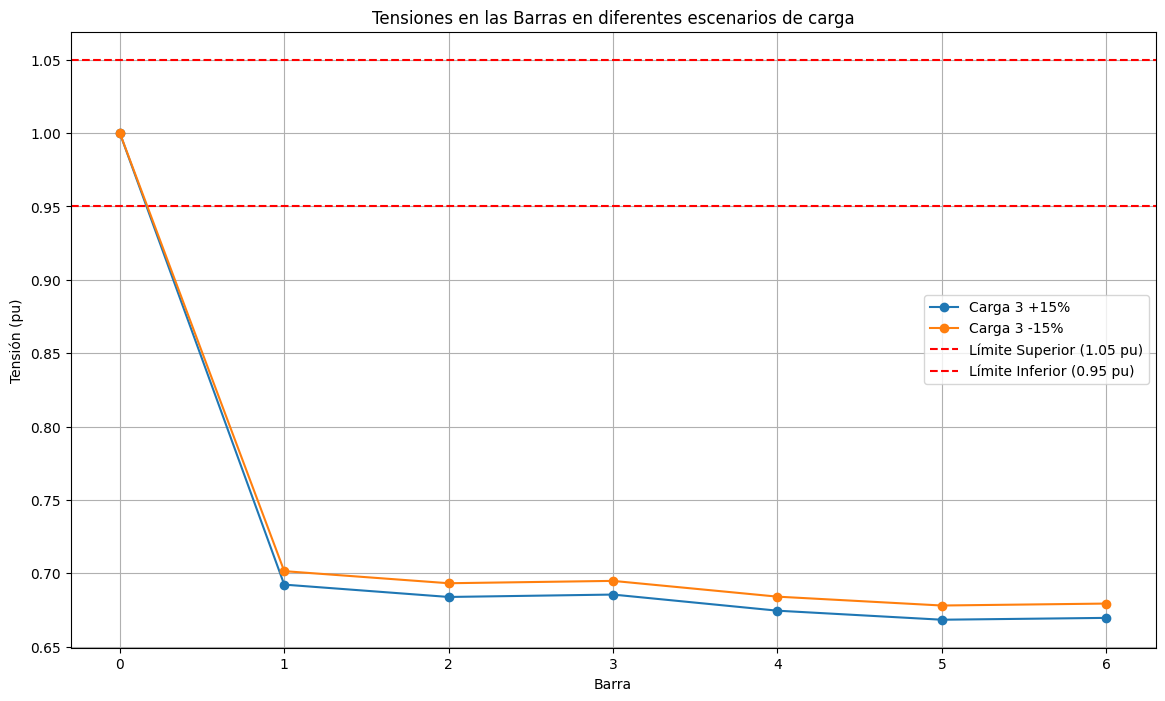

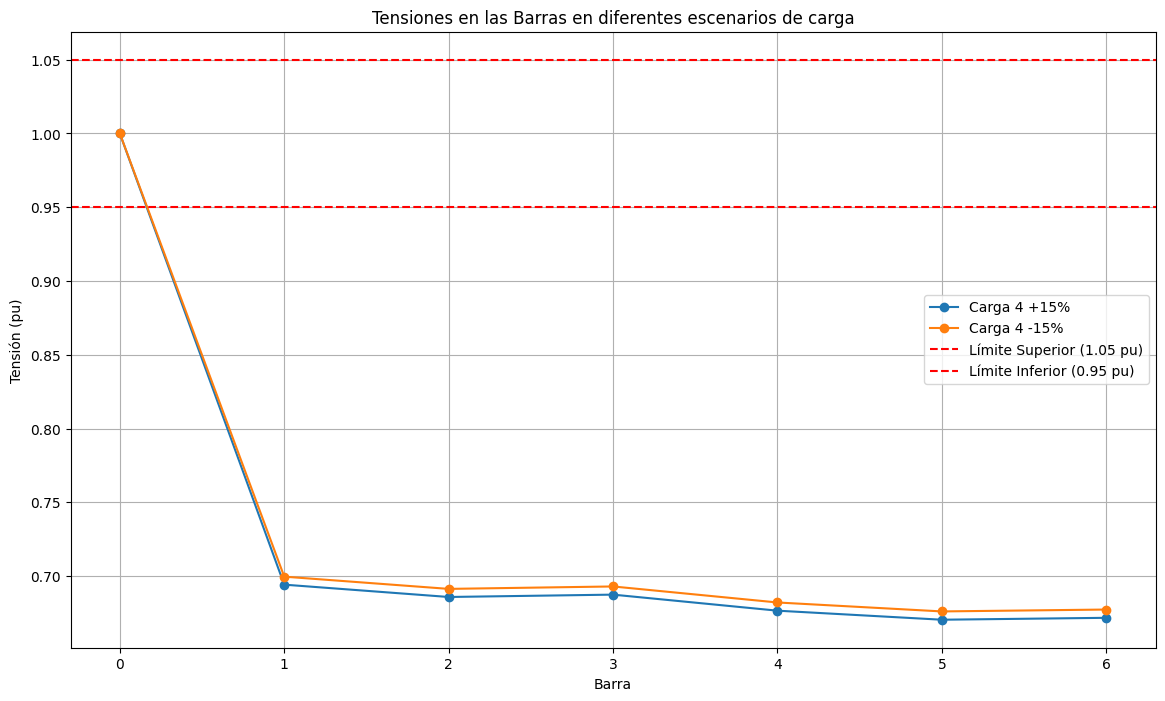

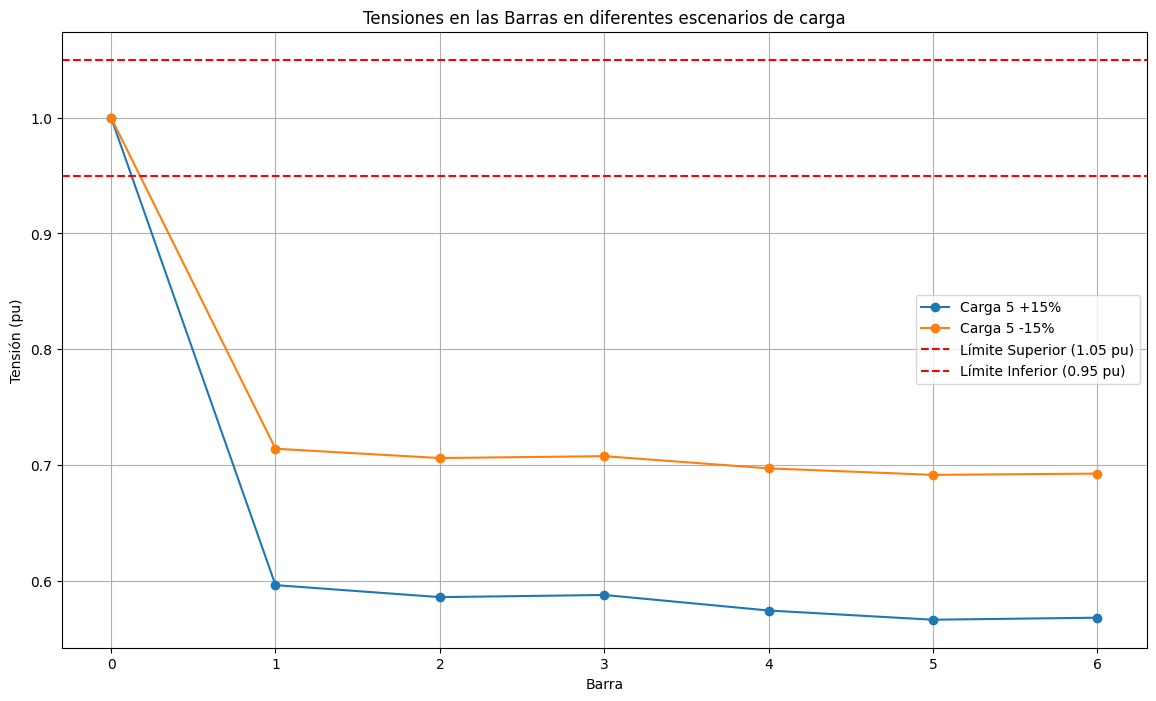

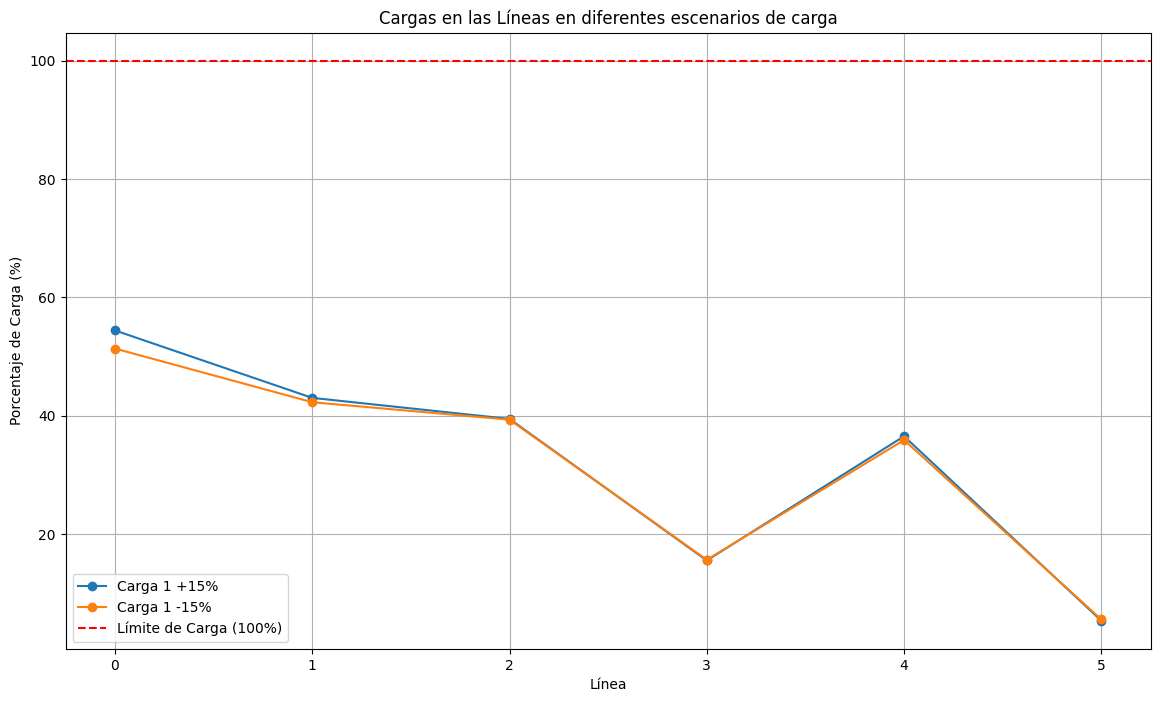

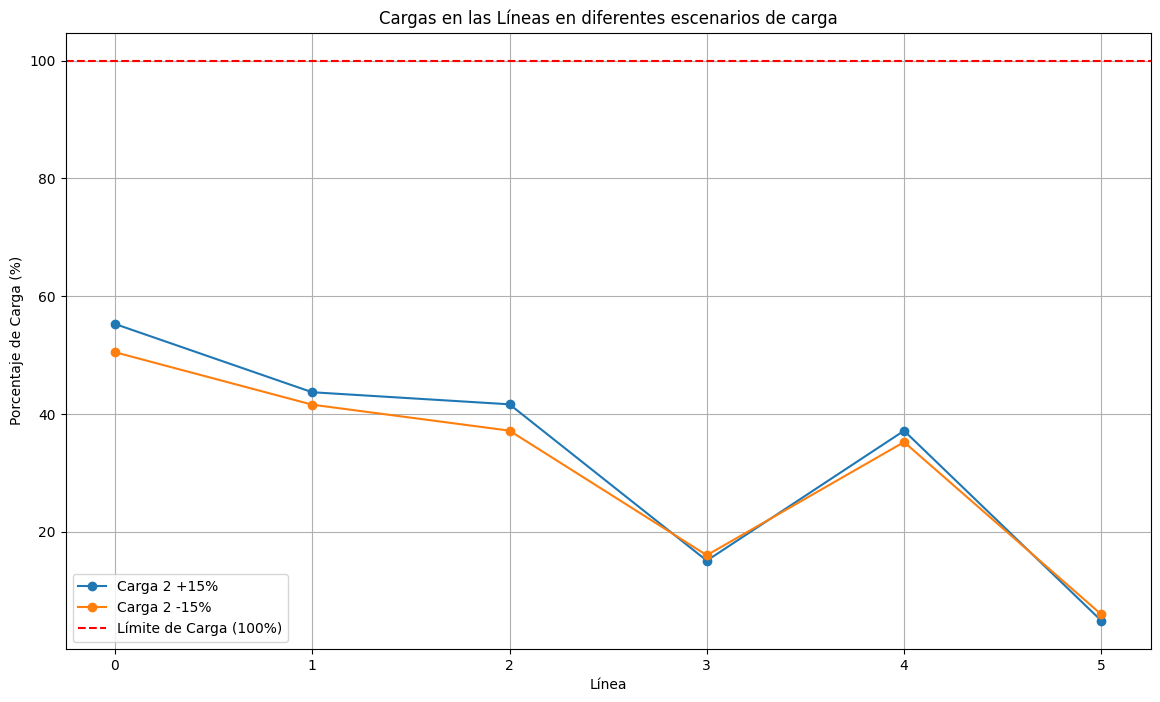

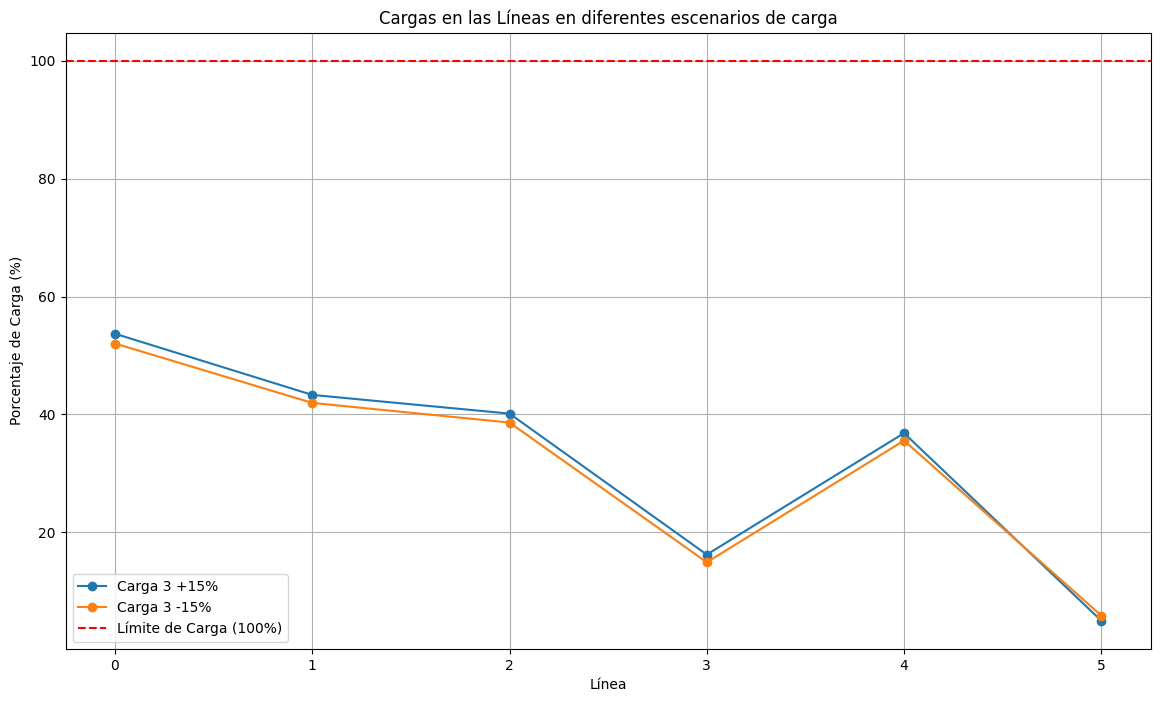

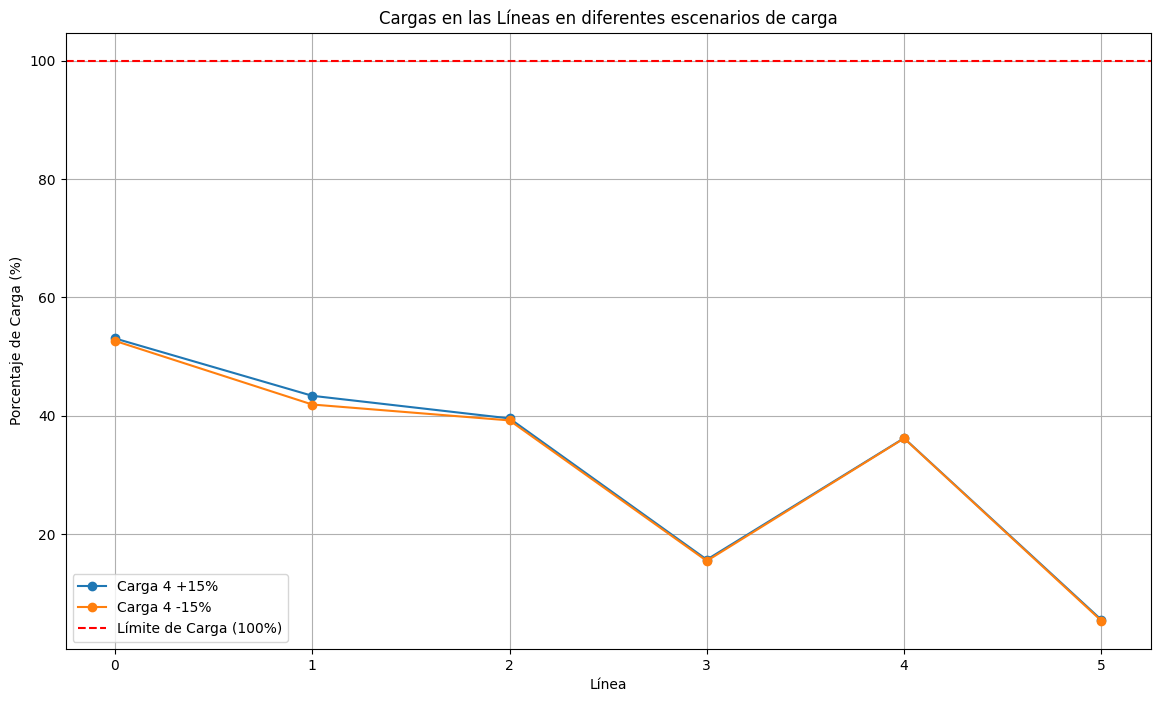

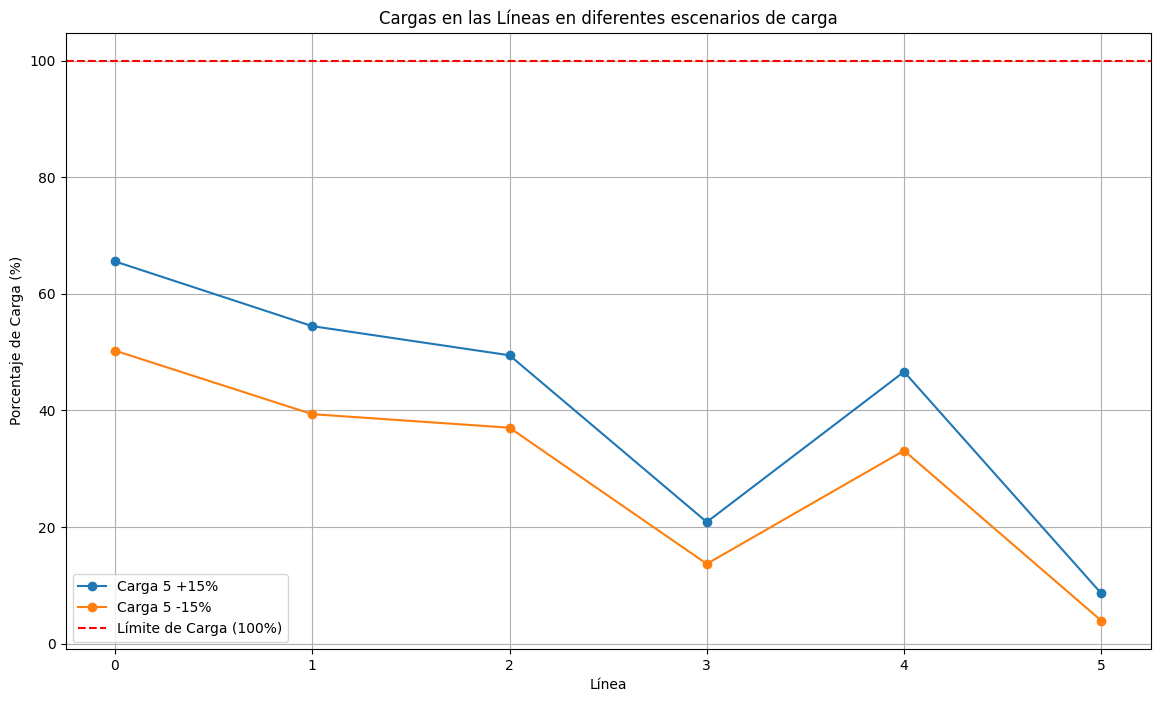

In [188]:
import numpy as np
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))

# Crear la red a analizar
red2 = pp.create_empty_network()

# Creación de las barras del sistema
barra_1 = pp.create_bus(red2, vn_kv=110, name="Barra 1")
barra_2 = pp.create_bus(red2, vn_kv=220, name="Barra 2")
barra_1A = pp.create_bus(red2, vn_kv=220, name="Barra 1A")
barra_1B = pp.create_bus(red2, vn_kv=220, name="Barra 1B")
barra_2A = pp.create_bus(red2, vn_kv=220, name="Barra 2A")
barra_2B = pp.create_bus(red2, vn_kv=220, name="Barra 2B")
barra_3A = pp.create_bus(red2, vn_kv=220, name="Barra 3A")

# Añadir transformador entre barra 1 y 2
pp.create_transformer(red2, barra_2, barra_1, std_type="100 MVA 220/110 kV")

# Añadir el generador en la barra 1 y que dicha barra sea la referencia
ext_grid_index = pp.create_ext_grid(red2, barra_1, va_pu=1.0, name="Slack")

# Crear las líneas utilizando el tipo de línea con menor capacidad de transferencia
linea_min_capacidad = "490-AL1/64-ST1A 220.0"  # Línea con menor capacidad de transferencia

# Crear las líneas
pp.create_line(red2, barra_2, barra_1A, length_km=10.0, std_type=linea_min_capacidad, name="L2-1A")
pp.create_line(red2, barra_2, barra_1B, length_km=10.0, std_type=linea_min_capacidad, name="L2-1B")
pp.create_line(red2, barra_1A, barra_2A, length_km=15.0, std_type=linea_min_capacidad, name="L1A-2A")
pp.create_line(red2, barra_2A, barra_3A, length_km=20.0, std_type=linea_min_capacidad, name="L2A-3A")
pp.create_line(red2, barra_1B, barra_2B, length_km=30.0, std_type=linea_min_capacidad, name="L1B-2B")
pp.create_line(red2, barra_2B, barra_3A, length_km=15.0, std_type=linea_min_capacidad, name="L2B-3A")

# Crear las cargas
load_indices = [
    pp.create_load(red2, barra_1A, p_mw=30.0, q_mvar=20.0, name="Carga Barra 1A"),
    pp.create_load(red2, barra_2A, p_mw=52.5, q_mvar=35.0, name="Carga Barra 2A"),
    pp.create_load(red2, barra_3A, p_mw=22.5, q_mvar=15.0, name="Carga Barra 3A"),
    pp.create_load(red2, barra_1B, p_mw=15.0, q_mvar=10.0, name="Carga Barra 1B"),
    pp.create_load(red2, barra_2B, p_mw=90.0, q_mvar=60.0, name="Carga Barra 2B")
]

# Definir la función para variar la carga
def vary_load_and_runpp(net, load_index, percentage_change):
    original_p = net.load.at[load_index, 'p_mw']
    net.load.at[load_index, 'p_mw'] = original_p * (1 + percentage_change)
    pp.runpp(net, algorithm='nr', numba=False, max_iteration=10000, tolerance_mva=8)
    voltages = net.res_bus.vm_pu.copy()
    line_loadings = net.res_line.loading_percent.copy()
    net.load.at[load_index, 'p_mw'] = original_p  # Revertir el cambio
    return voltages, line_loadings

# Crear escenarios y registrar resultados
scenarios = {}
change = 0.15
for load_index in load_indices:
    scenario_name = f"Carga {load_index + 1} {'+' if change > 0 else ''}{int(change*100)}%"
    voltages, line_loadings = vary_load_and_runpp(red2, load_index, change)
    if voltages is not None and line_loadings is not None:
        scenarios[scenario_name] = {
            "voltages": voltages,
            "line_loadings": line_loadings
        }
change = -0.15
for load_index in load_indices:
    scenario_name = f"Carga {load_index + 1} {'+' if change > 0 else ''}{int(change*100)}%"
    voltages, line_loadings = vary_load_and_runpp(red2, load_index, change)
    if voltages is not None and line_loadings is not None:
        scenarios[scenario_name] = {
            "voltages": voltages,
            "line_loadings": line_loadings
        }

for number in [1, 2, 3, 4, 5]:
    # Graficar los resultados de tensión
    plt.figure(figsize=(14, 8))
    for scenario, data in scenarios.items():
        if ("Carga " + str(number)) in scenario:
            plt.plot(red2.res_bus.index, data["voltages"], marker='o', linestyle='-', label=scenario)
    plt.axhline(y=1.05, color='r', linestyle='--', label='Límite Superior (1.05 pu)')
    plt.axhline(y=0.95, color='r', linestyle='--', label='Límite Inferior (0.95 pu)')
    plt.xlabel('Barra')
    plt.ylabel('Tensión (pu)')
    plt.title('Tensiones en las Barras en diferentes escenarios de carga')
    plt.legend()
    plt.grid(True)
    plt.show()

for number in [1, 2, 3, 4, 5]:
    # Graficar los resultados de carga de las líneas
    plt.figure(figsize=(14, 8))
    for scenario, data in scenarios.items():
        if ("Carga " + str(number)) in scenario:
            plt.plot(red2.res_line.index, data["line_loadings"], marker='o', linestyle='-', label=scenario)
    plt.axhline(y=100, color='r', linestyle='--', label='Límite de Carga (100%)')
    plt.xlabel('Línea')
    plt.ylabel('Porcentaje de Carga (%)')
    plt.title('Cargas en las Líneas en diferentes escenarios de carga')
    plt.legend()
    plt.grid(True)
    plt.show()



         vm_pu  va_degree       p_mw   q_mvar
name                                         
Barra 1 1.0000     0.0000 -1123.7309 110.4174
Barra 2 0.9184   -11.9631  1080.0000 523.0679
          p_from_mw  q_from_mvar   p_to_mw  q_to_mvar   pl_mw   ql_mvar  \
name                                                                      
Linea 1A   561.8654     -55.2087 -540.0000  -261.5339 21.8654 -316.7426   
Linea 1B   561.8654     -55.2087 -540.0000  -261.5339 21.8654 -316.7426   

          i_from_ka  i_to_ka   i_ka  vm_from_pu  va_from_degree  vm_to_pu  \
name                                                                        
Linea 1A     0.8149   0.9430 0.9430      1.0000          0.0000    0.9184   
Linea 1B     0.8149   0.9430 0.9430      1.0000          0.0000    0.9184   

          va_to_degree  loading_percent  
name                                     
Linea 1A      -11.9631          94.2957  
Linea 1B      -11.9631          94.2957  


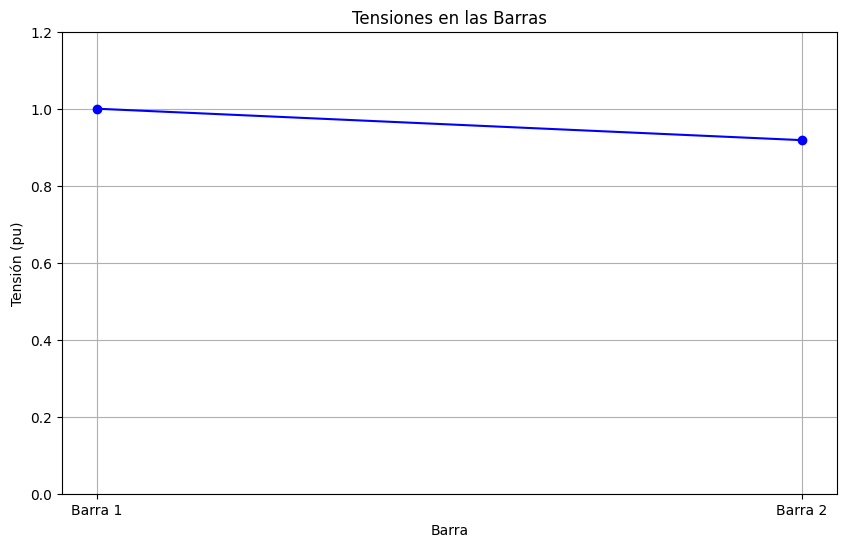

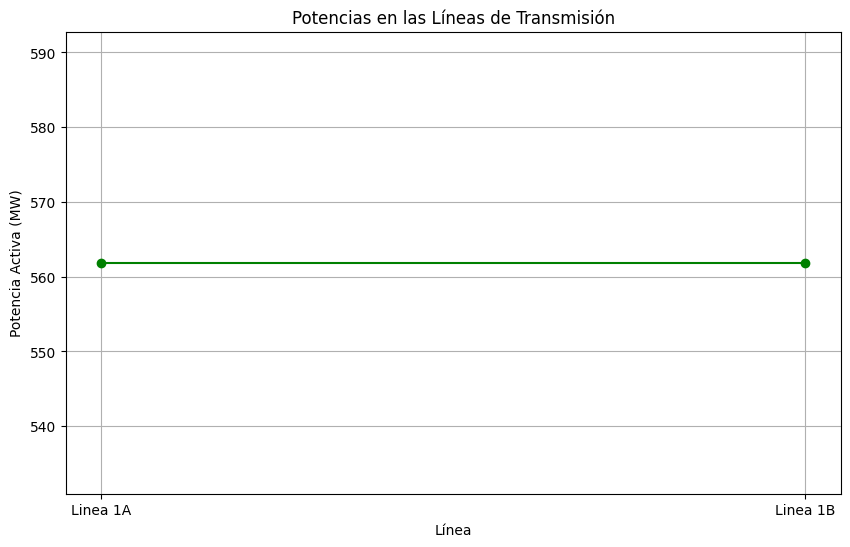

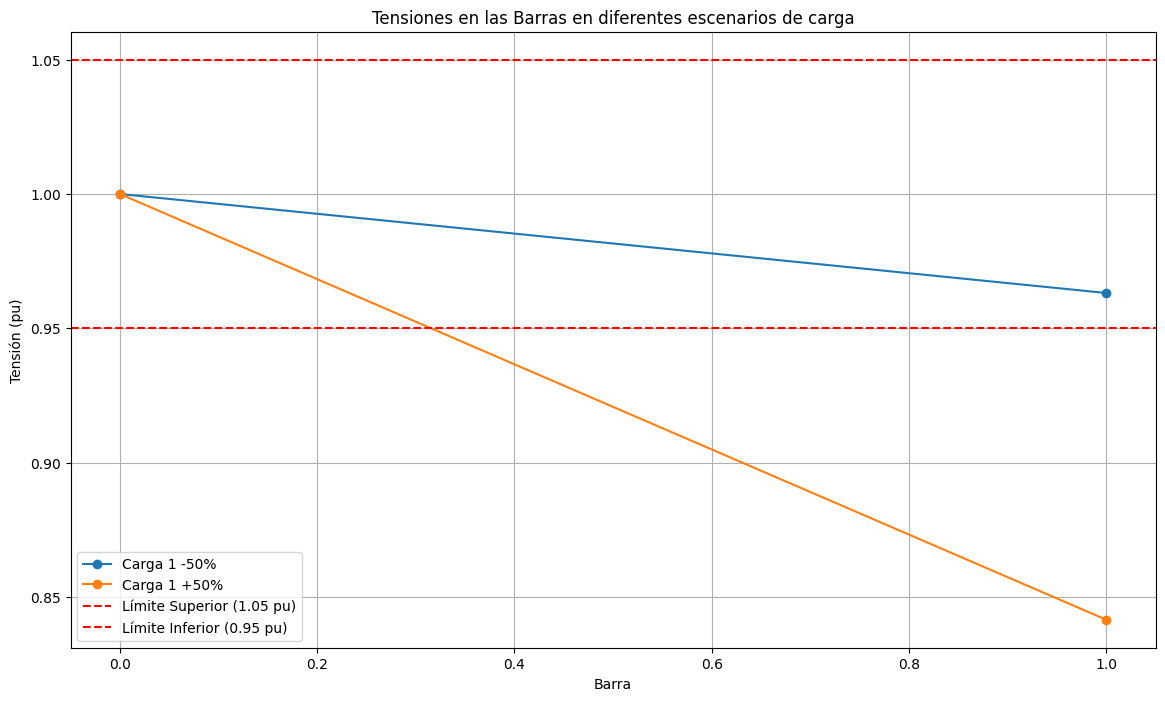

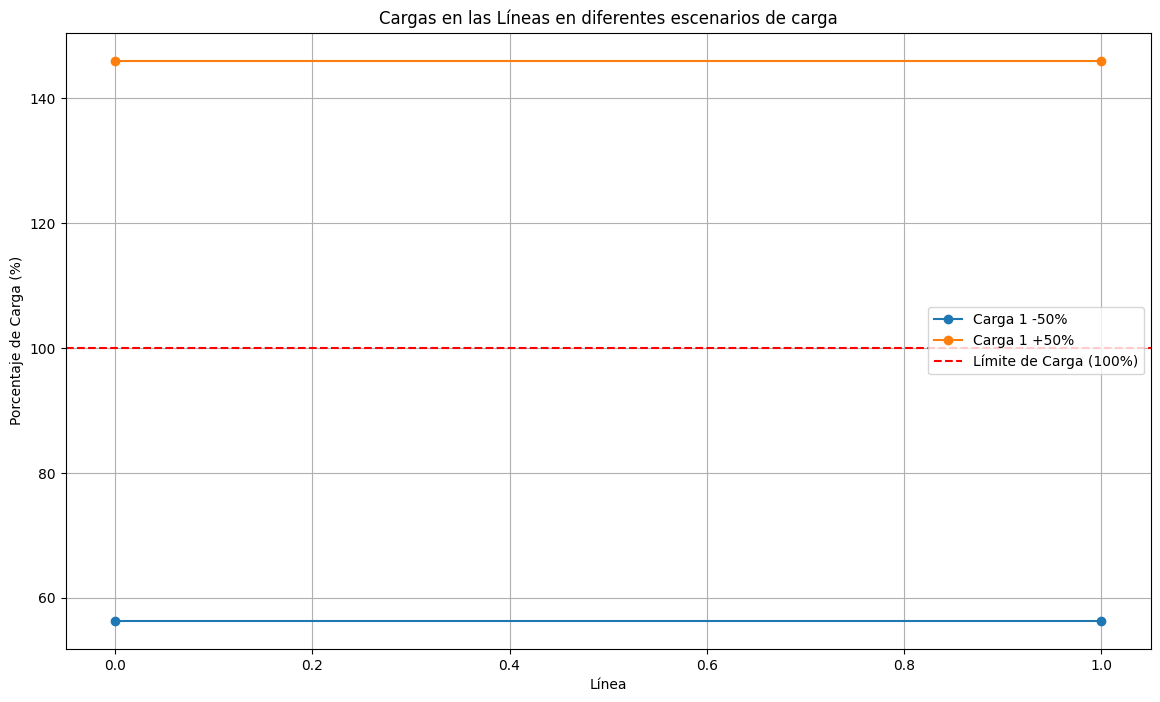

In [189]:
import numpy as np
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))

# Crear la red a analizar
red1 = pp.create_empty_network()

# Creación de las barras del sistema
barra_1 = pp.create_bus(red1, vn_kv=400, name="Barra 1")
barra_2 = pp.create_bus(red1, vn_kv=400, name="Barra 2")

#crear lineas
pp.create_line_from_parameters(net=red1, from_bus=barra_1, to_bus=barra_2, length_km=500, r_ohm_per_km=0.02,
                               x_ohm_per_km=0.115, c_nf_per_km=19.1, max_i_ka=1, name= "Linea 1A")
pp.create_line_from_parameters(net=red1, from_bus=barra_1, to_bus=barra_2, length_km=500, r_ohm_per_km=0.02,
                               x_ohm_per_km=0.115, c_nf_per_km=19.1, max_i_ka=1, name= "Linea 1B")

#crear generador
# Añadir el generador en la barra 1 y que dicha barra sea la referencia
pp.create_ext_grid(red1, barra_1, va_pu=1.0, name="Slack")


#crear la carga
load1=pp.create_load(red1, barra_2, p_mw=1080.0, q_mvar=523.0678732, name="Carga Barra 2")

# Ejecutar el flujo de carga
pp.runpp(red1, algorithm='nr', numba=False, max_iteration=1000)

# Imprimir los resultados
red1.res_line.index = red1.line.name
red1.res_bus.index = red1.bus.name

print(red1.res_bus)
print(red1.res_line)

# Graficar las tensiones en las barras
voltages = red1.res_bus.vm_pu
bars = red1.bus.name

plt.figure(figsize=(10, 6))
plt.plot(bars, voltages, marker='o', linestyle='-', color='blue')
plt.xlabel('Barra')
plt.ylabel('Tensión (pu)')
plt.title('Tensiones en las Barras')
plt.ylim([0, 1.2])
plt.grid(True)
plt.show()

# Graficar las potencias en las líneas de transmisión
powers = red1.res_line.p_from_mw
lines = red1.line.name

plt.figure(figsize=(10, 6))
plt.plot(lines, powers, marker='o', linestyle='-', color='green')
plt.xlabel('Línea')
plt.ylabel('Potencia Activa (MW)')
plt.title('Potencias en las Líneas de Transmisión')
plt.grid(True)
plt.show()

# Definir la función para variar la carga
def vary_load_and_runpp(net, load_index, percentage_change):
    original_p = net.load.at[load_index, 'p_mw']
    net.load.at[load_index, 'p_mw'] = original_p * (1 + percentage_change)
    pp.runpp(net, algorithm='nr', numba=False, max_iteration=10000, tolerance_mva=1)
    voltages = net.res_bus.vm_pu.copy()
    line_loadings = net.res_line.loading_percent.copy()
    net.load.at[load_index, 'p_mw'] = original_p  # Revertir el cambio
    return voltages, line_loadings

# Crear escenarios y registrar resultados
scenarios = {}
for change in [-0.5,0.5]:
    scenario_name = f"Carga {load1 + 1} {'+' if change > 0 else ''}{int(change*100)}%"
    voltages, line_loadings = vary_load_and_runpp(red1, load1, change)
    if voltages is not None and line_loadings is not None:
        scenarios[scenario_name] = {
            "voltages": voltages,
            "line_loadings": line_loadings
        }

# Graficar los resultados de tensión
plt.figure(figsize=(14, 8))
for scenario, data in scenarios.items():
    plt.plot(red1.res_bus.index, data["voltages"], marker='o', linestyle='-', label=scenario)
plt.axhline(y=1.05, color='r', linestyle='--', label='Límite Superior (1.05 pu)')
plt.axhline(y=0.95, color='r', linestyle='--', label='Límite Inferior (0.95 pu)')
plt.xlabel('Barra')
plt.ylabel('Tensión (pu)')
plt.title('Tensiones en las Barras en diferentes escenarios de carga')
plt.legend()
plt.grid(True)
plt.show()

# Graficar los resultados de carga de las líneas
plt.figure(figsize=(14, 8))
for scenario, data in scenarios.items():
    plt.plot(red1.res_line.index, data["line_loadings"], marker='o', linestyle='-', label=scenario)
plt.axhline(y=100, color='r', linestyle='--', label='Límite de Carga (100%)')
plt.xlabel('Línea')
plt.ylabel('Porcentaje de Carga (%)')
plt.title('Cargas en las Líneas en diferentes escenarios de carga')
plt.legend()
plt.grid(True)
plt.show()



         vm_pu  va_degree       p_mw   q_mvar
name                                         
Barra 1 1.0000     0.0000 -1123.7309 110.4174
Barra 2 0.9184   -11.9631  1080.0000 523.0679
          p_from_mw  q_from_mvar   p_to_mw  q_to_mvar   pl_mw   ql_mvar  \
name                                                                      
Linea 1A   561.8654     -55.2087 -540.0000  -261.5339 21.8654 -316.7426   
Linea 1B   561.8654     -55.2087 -540.0000  -261.5339 21.8654 -316.7426   

          i_from_ka  i_to_ka   i_ka  vm_from_pu  va_from_degree  vm_to_pu  \
name                                                                        
Linea 1A     0.8149   0.9430 0.9430      1.0000          0.0000    0.9184   
Linea 1B     0.8149   0.9430 0.9430      1.0000          0.0000    0.9184   

          va_to_degree  loading_percent  
name                                     
Linea 1A      -11.9631          94.2957  
Linea 1B      -11.9631          94.2957  


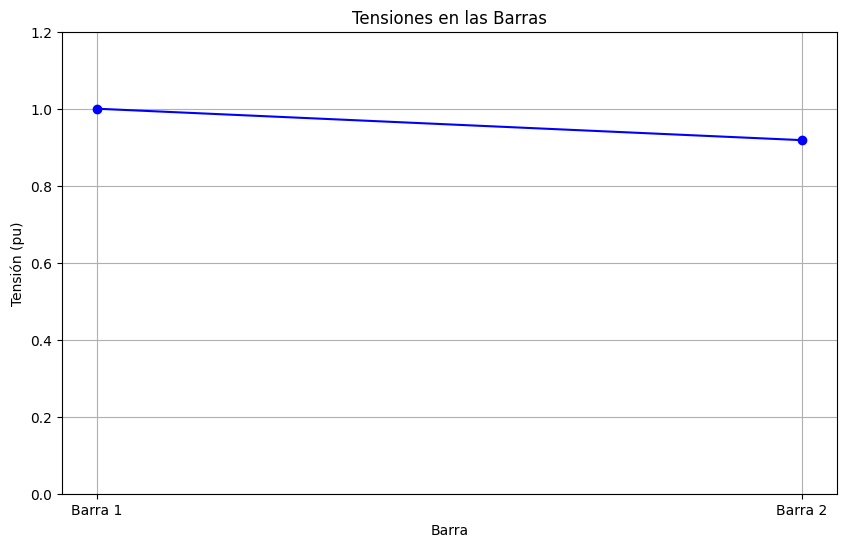

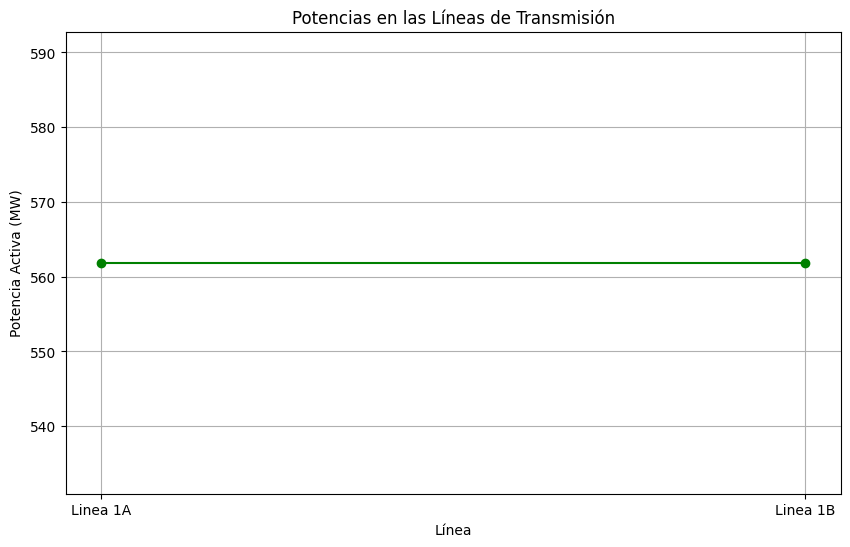

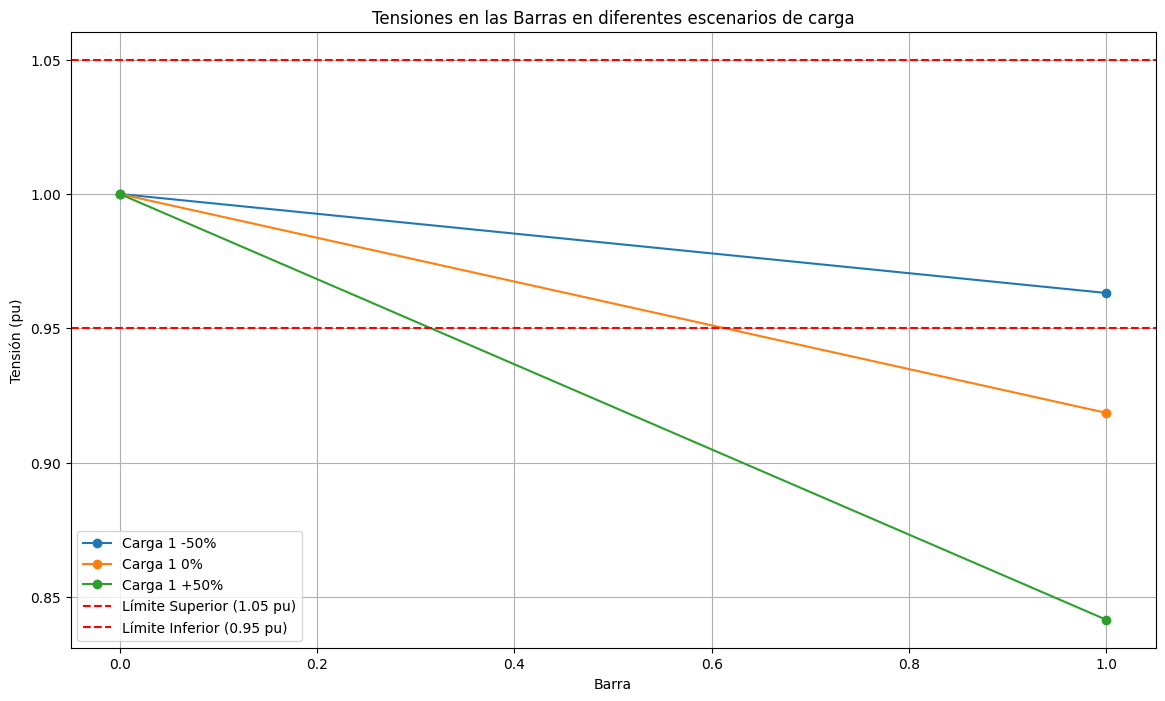

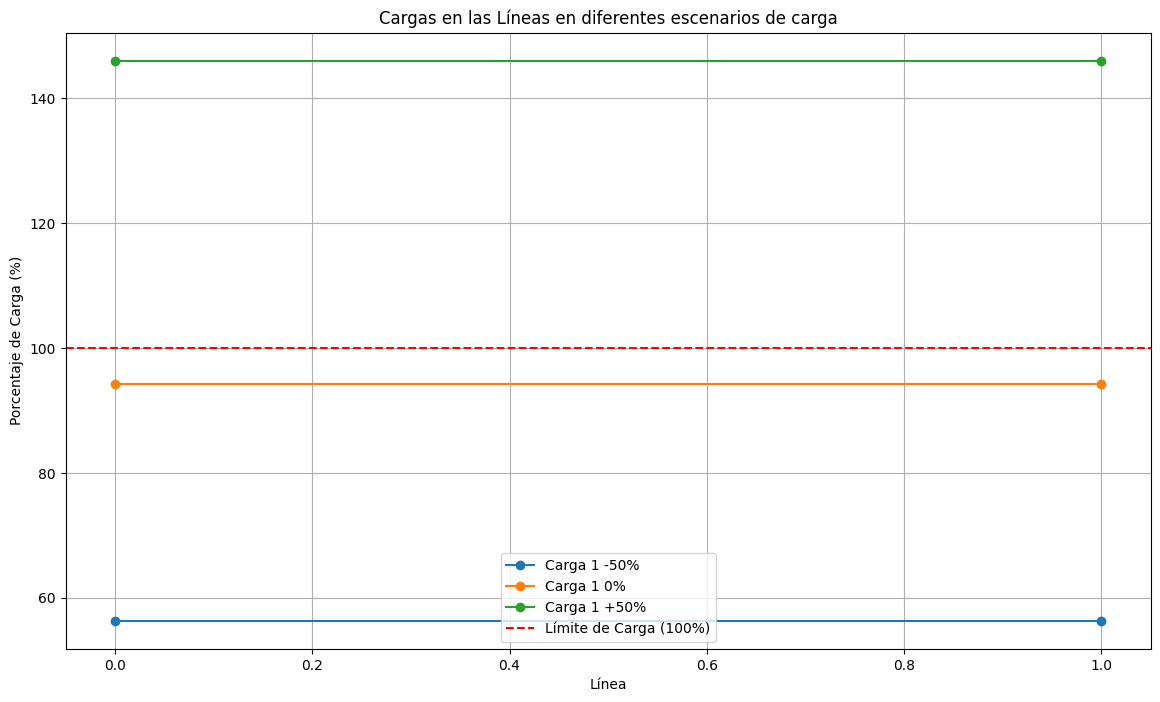

In [190]:
import numpy as np
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))

# Crear la red a analizar
red1 = pp.create_empty_network()

# Creación de las barras del sistema
barra_1 = pp.create_bus(red1, vn_kv=400, name="Barra 1")
barra_2 = pp.create_bus(red1, vn_kv=400, name="Barra 2")

#crear lineas
pp.create_line_from_parameters(net=red1, from_bus=barra_1, to_bus=barra_2, length_km=500, r_ohm_per_km=0.02,
                               x_ohm_per_km=0.115, c_nf_per_km=19.1, max_i_ka=1, name= "Linea 1A")
pp.create_line_from_parameters(net=red1, from_bus=barra_1, to_bus=barra_2, length_km=500, r_ohm_per_km=0.02,
                               x_ohm_per_km=0.115, c_nf_per_km=19.1, max_i_ka=1, name= "Linea 1B")

#crear generador
# Añadir el generador en la barra 1 y que dicha barra sea la referencia
pp.create_ext_grid(red1, barra_1, va_pu=1.0, name="Slack")


#crear la carga
load1=pp.create_load(red1, barra_2, p_mw=1080.0, q_mvar=523.0678732, name="Carga Barra 2")

# Ejecutar el flujo de carga
pp.runpp(red1, algorithm='nr', numba=False, max_iteration=1000)

# Imprimir los resultados
red1.res_line.index = red1.line.name
red1.res_bus.index = red1.bus.name

print(red1.res_bus)
print(red1.res_line)

# Graficar las tensiones en las barras
voltages = red1.res_bus.vm_pu
bars = red1.bus.name

plt.figure(figsize=(10, 6))
plt.plot(bars, voltages, marker='o', linestyle='-', color='blue')
plt.xlabel('Barra')
plt.ylabel('Tensión (pu)')
plt.title('Tensiones en las Barras')
plt.ylim([0, 1.2])
plt.grid(True)
plt.show()

# Graficar las potencias en las líneas de transmisión
powers = red1.res_line.p_from_mw
lines = red1.line.name

plt.figure(figsize=(10, 6))
plt.plot(lines, powers, marker='o', linestyle='-', color='green')
plt.xlabel('Línea')
plt.ylabel('Potencia Activa (MW)')
plt.title('Potencias en las Líneas de Transmisión')
plt.grid(True)
plt.show()

# Definir la función para variar la carga
def vary_load_and_runpp(net, load_index, percentage_change):
    original_p = net.load.at[load_index, 'p_mw']
    net.load.at[load_index, 'p_mw'] = original_p * (1 + percentage_change)
    pp.runpp(net, algorithm='nr', numba=False, max_iteration=10000, tolerance_mva=1)
    voltages = net.res_bus.vm_pu.copy()
    line_loadings = net.res_line.loading_percent.copy()
    net.load.at[load_index, 'p_mw'] = original_p  # Revertir el cambio
    return voltages, line_loadings

# Crear escenarios y registrar resultados
scenarios = {}
for change in [-0.5,0.0,0.5]:
    scenario_name = f"Carga {load1 + 1} {'+' if change > 0 else ''}{int(change*100)}%"
    voltages, line_loadings = vary_load_and_runpp(red1, load1, change)
    if voltages is not None and line_loadings is not None:
        scenarios[scenario_name] = {
            "voltages": voltages,
            "line_loadings": line_loadings
        }

# Graficar los resultados de tensión
plt.figure(figsize=(14, 8))
for scenario, data in scenarios.items():
    plt.plot(red1.res_bus.index, data["voltages"], marker='o', linestyle='-', label=scenario)
plt.axhline(y=1.05, color='r', linestyle='--', label='Límite Superior (1.05 pu)')
plt.axhline(y=0.95, color='r', linestyle='--', label='Límite Inferior (0.95 pu)')
plt.xlabel('Barra')
plt.ylabel('Tensión (pu)')
plt.title('Tensiones en las Barras en diferentes escenarios de carga')
plt.legend()
plt.grid(True)
plt.show()

# Graficar los resultados de carga de las líneas
plt.figure(figsize=(14, 8))
for scenario, data in scenarios.items():
    plt.plot(red1.res_line.index, data["line_loadings"], marker='o', linestyle='-', label=scenario)
plt.axhline(y=100, color='r', linestyle='--', label='Límite de Carga (100%)')
plt.xlabel('Línea')
plt.ylabel('Porcentaje de Carga (%)')
plt.title('Cargas en las Líneas en diferentes escenarios de carga')
plt.legend()
plt.grid(True)
plt.show()

